In [8]:
import random
import os
import numpy as np
import mxnet as mx

def seed_everything():
    random.seed(42)
    np.random.seed(42)
    mx.random.seed(42)
    
seed_everything()

from deeprenewal._datasets import get_dataset
from gluonts.dataset.util import to_pandas
from deeprenewal.deeprenewal._estimator import DeepRenewalEstimator
from deeprenewal.croston._estimator import CrostonForecastPredictor
from deeprenewal._evaluator import IntermittentEvaluator
from gluonts.model.deepar import DeepAREstimator
from gluonts.distribution.neg_binomial import NegativeBinomialOutput
from gluonts.distribution.piecewise_linear import PiecewiseLinearOutput
from gluonts.distribution.student_t import StudentTOutput
from gluonts.model.r_forecast import RForecastPredictor
from gluonts.model.prophet import ProphetPredictor
from gluonts.model.npts import NPTSPredictor
from gluonts.evaluation import Evaluator
from gluonts.trainer import Trainer
from gluonts.evaluation.backtest import make_evaluation_predictions 
import mxnet as mx
import ast
from tqdm import tqdm
from argparse import ArgumentParser
from gluonts.model.forecast import SampleForecast
# from croston import croston
from fbprophet import Prophet
from pathlib import Path
from gluonts.model.predictor import Predictor
import pandas as pd

# Config

In [9]:
parser = ArgumentParser()
parser.add_argument("-f", "--fff", help="a dummy argument to fool ipython", default="1")

# add PROGRAM level args
parser.add_argument('--use-cuda', type=bool, default=True)
parser.add_argument('--log-gradients', type=bool, default=True)
parser.add_argument('--datasource', type=str, default="retail_dataset")
parser.add_argument('--model-save-dir', type=str, default="saved_models")

# Trainer specific args
parser.add_argument('--batch_size', type=int, default=32)
parser.add_argument('--learning-rate', type=float, default=1e-2)
parser.add_argument('--max-epochs', type=int, default=10)
parser.add_argument('--number-of-batches-per-epoch', type=int, default=100)
parser.add_argument('--clip-gradient', type=float, default=5.170127652392614)
parser.add_argument('--weight-decay', type=float, default=0.01)


# Model specific args
parser.add_argument('--context-length-multiplier', type=int, default=2)
parser.add_argument('--num-layers', type=int, default=2)
parser.add_argument('--num-cells', type=int, default=64)
parser.add_argument('--cell-type', type=str, default="lstm")
#p% are dropped and set to zero
parser.add_argument('--dropout-rate', type=float, default=0.3)
parser.add_argument('--use-feat-dynamic-real', type=bool, default=False)
parser.add_argument('--use-feat-static-cat', type=bool, default=False)
parser.add_argument('--use-feat-static-real', type=bool, default=False)
parser.add_argument('--scaling', type=bool, default=True)
parser.add_argument('--num-parallel-samples', type=int, default=100)
parser.add_argument('--num-lags', type=int, default=1)
#Only for Deep Renewal Processes
parser.add_argument('--forecast-type', type=str, default="hybrid")
#Only for Deep AR
parser.add_argument('--distr-output', type=str, default="student_t") #neg_binomial

args = parser.parse_args()
is_gpu = mx.context.num_gpus()>0

# Read in the dataset

In [10]:
dataset = get_dataset(args.datasource, regenerate=False)

In [11]:
prediction_length = dataset.metadata.prediction_length
freq = dataset.metadata.freq
cardinality = ast.literal_eval(dataset.metadata.feat_static_cat[0].cardinality)
train_ds = dataset.train
test_ds = dataset.test

# Baselines

## ETS

In [8]:
ets_predictor = RForecastPredictor(freq= freq, 
                                   prediction_length= prediction_length, 
                                   method_name = 'ets', 
                                   )

ets_forecast = list(ets_predictor.predict(train_ds))

## Arima

In [9]:
arima_predictor = RForecastPredictor(freq= freq, 
                                   prediction_length= prediction_length, 
                                   method_name = 'arima', 
                                   )

arima_forecast = list(arima_predictor.predict(train_ds))

## Croston

In [10]:
croston_predictor = CrostonForecastPredictor(freq= freq, 
                                   prediction_length= prediction_length, 
                                   variant = 'original',
                                    no_of_params=2
                                   )

croston_forecast = list(croston_predictor.predict(train_ds))

## SBA

In [11]:
sba_predictor = CrostonForecastPredictor(freq= freq, 
                                   prediction_length= prediction_length, 
                                   variant = 'sba',
                                    no_of_params=2
                                   )

sba_forecast = list(sba_predictor.predict(train_ds))

## SBJ

In [12]:
sbj_predictor = CrostonForecastPredictor(freq= freq, 
                                   prediction_length= prediction_length, 
                                   variant = 'sbj',
                                    no_of_params=2
                                   )

sbj_forecast = list(sbj_predictor.predict(train_ds))

D:\Playground\ts_research\deep_renewal\deeprenewal\models\croston\croston.py:118: RuntimeWarning:

overflow encountered in double_scalars

D:\Playground\ts_research\deep_renewal\deeprenewal\models\croston\croston.py:117: RuntimeWarning:

overflow encountered in double_scalars

D:\Playground\ts_research\deep_renewal\deeprenewal\models\croston\croston.py:120: RuntimeWarning:

invalid value encountered in double_scalars

D:\Playground\ts_research\deep_renewal\deeprenewal\models\croston\croston.py:120: RuntimeWarning:

invalid value encountered in true_divide

D:\Playground\ts_research\deep_renewal\deeprenewal\models\croston\croston.py:120: RuntimeWarning:

overflow encountered in double_scalars

D:\Playground\ts_research\deep_renewal\deeprenewal\models\croston\croston.py:120: RuntimeWarning:

overflow encountered in multiply

D:\Playground\ts_research\deep_renewal\deeprenewal\models\croston\croston.py:118: RuntimeWarning:

invalid value encountered in double_scalars



## NPTS

In [30]:
npts_predictor = NPTSPredictor(freq=freq, prediction_length=prediction_length, context_length=300, kernel_type='uniform', use_seasonal_model=False)

npts_forecast = list(npts_predictor.predict(train_ds))

## DeepAR

In [19]:
# if args.distr_output=="neg_binomial":
#     distr = NegativeBinomialOutput()
# elif args.distr_output == "student_t":
#     distr = StudentTOutput()

distr = PiecewiseLinearOutput(7)

deep_ar_trainer = Trainer(ctx=mx.context.gpu() if is_gpu&args.use_cuda else mx.context.cpu(), 
                  batch_size=128,
                  learning_rate=1e-2,
                  epochs=20,
                  num_batches_per_epoch=args.number_of_batches_per_epoch,
                  clip_gradient=5.48481845049343,
                  weight_decay=0.001,
                  hybridize=True) #hybridize false for development

deep_ar_estimator = DeepAREstimator(
    prediction_length=prediction_length,
    context_length=prediction_length*2,
    num_layers=2,
    num_cells=128,
    cell_type='gru',
    dropout_rate=0.1,
    scaling=True,
    lags_seq=np.arange(1,1+1).tolist(),
    freq=freq,
    use_feat_dynamic_real=False,
    use_feat_static_cat=False,
    use_feat_static_real=False,
    distr_output=distr,
    cardinality=None,#cardinality,
    trainer=deep_ar_trainer,
)
deep_ar_predictor = deep_ar_estimator.train(train_ds, test_ds)

100%|███████████████████████████████████████████████| 100/100 [00:30<00:00,  3.26it/s, epoch=1/20, avg_epoch_loss=5.12]
17it [00:03,  5.04it/s, epoch=1/20, validation_avg_epoch_loss=4.73]
100%|███████████████████████████████████████████████| 100/100 [00:30<00:00,  3.32it/s, epoch=2/20, avg_epoch_loss=4.36]
17it [00:03,  5.52it/s, epoch=2/20, validation_avg_epoch_loss=4.61]
100%|███████████████████████████████████████████████| 100/100 [00:30<00:00,  3.30it/s, epoch=3/20, avg_epoch_loss=4.84]
16it [00:02,  5.57it/s, epoch=3/20, validation_avg_epoch_loss=4.51]
100%|███████████████████████████████████████████████| 100/100 [00:30<00:00,  3.32it/s, epoch=4/20, avg_epoch_loss=4.16]
16it [00:03,  5.26it/s, epoch=4/20, validation_avg_epoch_loss=4.41]
100%|███████████████████████████████████████████████| 100/100 [00:30<00:00,  3.33it/s, epoch=5/20, avg_epoch_loss=4.32]
17it [00:03,  5.13it/s, epoch=5/20, validation_avg_epoch_loss=4.43]
100%|███████████████████████████████████████████████| 100/10

In [20]:
# save the trained model
os.makedirs(args.model_save_dir, exist_ok=True)
os.makedirs(Path(args.model_save_dir)/"deep_ar_baseline", exist_ok=True)
deep_ar_predictor.serialize(Path(args.model_save_dir)/"deep_ar_baseline")

In [21]:
# deep_ar_predictor = Predictor.deserialize(Path(args.model_save_dir)/"deep_ar_baseline")
print("Generating Deep AR forecasts.......")
deep_ar_forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds, predictor=deep_ar_predictor, num_samples=100
)
tss = list(tqdm(ts_it, total=len(test_ds)))
deep_ar_forecasts = list(tqdm(deep_ar_forecast_it, total=len(test_ds)))

 11%|████████▋                                                                    | 205/1822 [00:00<00:00, 2035.15it/s]

Generating Deep AR forecasts.......


100%|██████████████████████████████████████████████████████████████████████████████| 1822/1822 [00:45<00:00, 40.35it/s]


# DeepRenewal

In [24]:
trainer = Trainer(ctx=mx.context.gpu() if is_gpu&args.use_cuda else mx.context.cpu(), 
                  batch_size=args.batch_size,
                  learning_rate=args.learning_rate,
                  epochs=20,
                  num_batches_per_epoch=args.number_of_batches_per_epoch,
                  clip_gradient=args.clip_gradient,
                  weight_decay=args.weight_decay,
                  hybridize=True) #hybridize false for development

estimator = DeepRenewalEstimator(
    prediction_length=prediction_length,
    context_length=prediction_length*args.context_length_multiplier,
    num_layers=args.num_layers,
    num_cells=args.num_cells,
    cell_type=args.cell_type,
    dropout_rate=args.dropout_rate,
    scaling=True,
    lags_seq=np.arange(1,args.num_lags+1).tolist(),
    freq=freq,
    use_feat_dynamic_real=args.use_feat_dynamic_real,
    use_feat_static_cat=args.use_feat_static_cat,
    use_feat_static_real=args.use_feat_static_real,
    cardinality=cardinality if args.use_feat_static_cat else None,
    trainer=trainer,
)
predictor = estimator.train(train_ds, test_ds)

100%|███████████████████████████████████████████████| 100/100 [00:26<00:00,  3.79it/s, epoch=1/20, avg_epoch_loss=6.13]
67it [00:12,  5.47it/s, epoch=1/20, validation_avg_epoch_loss=6.14]
100%|███████████████████████████████████████████████| 100/100 [00:26<00:00,  3.70it/s, epoch=2/20, avg_epoch_loss=6.07]
65it [00:12,  5.40it/s, epoch=2/20, validation_avg_epoch_loss=6.1] 
100%|████████████████████████████████████████████████| 100/100 [00:27<00:00,  3.66it/s, epoch=3/20, avg_epoch_loss=6.1]
70it [00:12,  5.77it/s, epoch=3/20, validation_avg_epoch_loss=6.14]
100%|███████████████████████████████████████████████| 100/100 [00:26<00:00,  3.72it/s, epoch=4/20, avg_epoch_loss=6.09]
66it [00:12,  5.43it/s, epoch=4/20, validation_avg_epoch_loss=6.12]
100%|███████████████████████████████████████████████| 100/100 [00:26<00:00,  3.71it/s, epoch=5/20, avg_epoch_loss=6.08]
66it [00:12,  5.36it/s, epoch=5/20, validation_avg_epoch_loss=6.11]
100%|███████████████████████████████████████████████| 100/10

In [25]:
# save the trained model
os.makedirs(args.model_save_dir, exist_ok=True)
os.makedirs(Path(args.model_save_dir)/"deeprenewal", exist_ok=True)
predictor.serialize(Path(args.model_save_dir)/"deeprenewal")

In [27]:
print("Generating DeepRenewal forecasts.......")
# predictor = Predictor.deserialize(Path(args.model_save_dir)/"deeprenewal")
deep_renewal_flat_forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds, predictor=predictor, num_samples=100
)
# tss = list(tqdm(ts_it, total=len(test_ds)))
deep_renewal_flat_forecasts = list(tqdm(deep_renewal_flat_forecast_it, total=len(test_ds)))

#Deep Renewal Exact
predictor.forecast_generator.forecast_type = "exact"
deep_renewal_exact_forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds, predictor=predictor, num_samples=100
)
deep_renewal_exact_forecasts = list(tqdm(deep_renewal_exact_forecast_it, total=len(test_ds)))
#Deep Renewal Hybrid
predictor.forecast_generator.forecast_type = "hybrid"
deep_renewal_hybrid_forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds, predictor=predictor, num_samples=100
)
deep_renewal_hybrid_forecasts = list(tqdm(deep_renewal_hybrid_forecast_it, total=len(test_ds)))

  0%|                                                                                         | 0/1822 [00:00<?, ?it/s]WARNING:root:You have set `num_workers` to a non zero value, however, currently multiprocessing is not supported on windows and therefore`num_workers will be set to 0.


Generating DeepRenewal forecasts.......


D:\Playground\ts_research\deep_renewal\deeprenewal\models\deeprenewal\_forecast_generator.py:69: RuntimeWarning:

divide by zero encountered in true_divide

D:\Playground\ts_research\deep_renewal\deeprenewal\models\deeprenewal\_forecast_generator.py:69: RuntimeWarning:

invalid value encountered in true_divide

100%|██████████████████████████████████████████████████████████████████████████████| 1822/1822 [01:27<00:00, 20.79it/s]


# Evaluation

In [32]:
import joblib
joblib.dump({
    "ets":ets_forecast,
    "arima": arima_forecast,
    "croston": croston_forecast,
    "sba": sba_forecast,
    "sbj": sbj_forecast,
    "npts":npts_forecast,
    "deep_ar": deep_ar_forecasts,
    "deep_renewal_flat": deep_renewal_flat_forecasts,
    "deep_renewal_exact":deep_renewal_exact_forecasts,
    "deep_renewal_hybrid": deep_renewal_hybrid_forecasts
}, "forecast_dict.sav")

['forecast_dict.sav']

In [16]:
forecast_dict = joblib.load("forecast_dict.sav")

In [18]:
import matplotlib.pyplot as plt

In [19]:
def plot_prob_forecasts(ts_entry, forecast_entry):
    plot_length = 150
    prediction_intervals = (50.0, 90.0)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    ts_entry[-plot_length:].plot(ax=ax)  # plot the time series
    forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")
    plt.show()

In [ ]:
dp_r_flat = forecast_dict['deep_renewal_flat']


In [33]:
evaluator = IntermittentEvaluator(quantiles=[0.25,0.5,0.75], median=False, calculate_spec=False)
#DeepAR
deep_ar_agg_metrics, deep_ar_item_metrics = evaluator(
    iter(tss), iter(deep_ar_forecasts), num_series=len(test_ds)
)
#Croston
croston_agg_metrics, croston_item_metrics = evaluator(
    iter(tss), iter(croston_forecast), num_series=len(test_ds)
)
#SBA
sba_agg_metrics, sba_item_metrics = evaluator(
    iter(tss), iter(sba_forecast), num_series=len(test_ds)
)
#SBJ
sbj_agg_metrics, sbj_item_metrics = evaluator(
    iter(tss), iter(sbj_forecast), num_series=len(test_ds)
)
#NPTS
npts_agg_metrics, npts_item_metrics = evaluator(
    iter(tss), iter(npts_forecast), num_series=len(test_ds)
)
#ETS
ets_agg_metrics, ets_item_metrics = evaluator(
    iter(tss), iter(ets_forecast), num_series=len(test_ds)
)
#Arima
arima_agg_metrics, arima_item_metrics = evaluator(
    iter(tss), iter(arima_forecast), num_series=len(test_ds)
)
#DeepRenewal Flat
deep_renewal_flat_agg_metrics, deep_renewal_flat_item_metrics = evaluator(
    iter(tss), iter(deep_renewal_flat_forecasts), num_series=len(test_ds)
)
#Deep Renewal Exact
deep_renewal_exact_agg_metrics, deep_renewal_exact_item_metrics = evaluator(
    iter(tss), iter(deep_renewal_exact_forecasts), num_series=len(test_ds)
)
#Deep Renewal Hybrid
deep_renewal_hybrid_agg_metrics, deep_renewal_hybrid_item_metrics = evaluator(
    iter(tss), iter(deep_renewal_hybrid_forecasts), num_series=len(test_ds)
)

Running evaluation:   0%|                                                                     | 0/1822 [00:00<?, ?it/s]D:\Playground\ts_research\deep_renewal\deeprenewal\models\_evaluator.py:226: RuntimeWarning:

divide by zero encountered in true_divide

D:\Playground\ts_research\deep_renewal\deeprenewal\models\_evaluator.py:267: RuntimeWarning:

divide by zero encountered in double_scalars

D:\Playground\ts_research\deep_renewal\deeprenewal\models\_evaluator.py:269: RuntimeWarning:

divide by zero encountered in double_scalars

Running evaluation: 100%|█████████████████████████████████████████████████████████| 1822/1822 [00:14<00:00, 121.65it/s]
D:\miniconda3\envs\timeseries\lib\site-packages\pandas\core\dtypes\cast.py:1507: UserWarning:


Running evaluation: 100%|█████████████████████████████████████████████████████████| 1822/1822 [00:14<00:00, 123.60it/s]


In [34]:
deep_ar_agg_metrics['method'] = "DeepAR"
croston_agg_metrics['method'] = "Croston"
sba_agg_metrics['method'] = "SBA"
sbj_agg_metrics['method'] = "SBJ"
npts_agg_metrics['method'] = "NPTS"
arima_agg_metrics['method'] = "ARIMA"
ets_agg_metrics['method'] = "ETS"
deep_renewal_flat_agg_metrics['method'] = "DeepRenewal Flat"
deep_renewal_exact_agg_metrics['method'] = "DeepRenewal Exact"
deep_renewal_hybrid_agg_metrics['method'] = "DeepRenewal Hybrid"

In [35]:
pd.set_option('display.max_columns', 500)

In [12]:
import joblib

In [36]:
joblib.dump([deep_ar_agg_metrics,
                          croston_agg_metrics,
             sba_agg_metrics,
             sbj_agg_metrics,
             npts_agg_metrics,
                          arima_agg_metrics, 
                          ets_agg_metrics, 
                          deep_renewal_flat_agg_metrics, 
                          deep_renewal_exact_agg_metrics,
                          deep_renewal_hybrid_agg_metrics], "metrics.pkl")

['metrics.pkl']

In [13]:
[deep_ar_agg_metrics,
                          croston_agg_metrics,
             sba_agg_metrics,
             sbj_agg_metrics,
             npts_agg_metrics,
                          arima_agg_metrics, 
                          ets_agg_metrics, 
                          deep_renewal_flat_agg_metrics, 
                          deep_renewal_exact_agg_metrics,
                          deep_renewal_hybrid_agg_metrics] = joblib.load("metrics.pkl")

In [14]:
result_df = pd.DataFrame([deep_ar_agg_metrics,
                          croston_agg_metrics,
             sba_agg_metrics,
             sbj_agg_metrics,
             npts_agg_metrics,
                          arima_agg_metrics, 
                          ets_agg_metrics, 
                          deep_renewal_flat_agg_metrics, 
                          deep_renewal_exact_agg_metrics,
                          deep_renewal_hybrid_agg_metrics])
result_df

,MSE,MAE,MRAE,MASE,MAPE,MAAPE,sMAPE,abs_target_sum,abs_target_mean,abs_error,...,RelMAE,RelRMSE,NRMSE,ND,wQuantileLoss[0.25],wQuantileLoss[0.5],wQuantileLoss[0.75],mean_wQuantileLoss,MAE_Coverage,method
0,1490.849999,9.420458,1.074516,1.075122,0.626764,0.635660,1.481585,765651.0,10.775015,669398.893675,...,0.019472,0.148824,3.583431,0.874287,0.493981,0.887954,1.055750,0.812562,0.242187,DeepAR
1,1621.297347,11.144141,0.896252,1.400758,0.649216,0.634243,1.510919,765651.0,10.775015,791880.385754,...,0.023035,0.155198,3.736917,1.034258,0.868407,1.034258,1.200108,1.034258,0.211203,Croston
2,1641.804053,10.921846,0.878738,1.350970,0.611183,0.635039,1.523079,765651.0,10.775015,776084.551921,...,0.022575,0.156177,3.760476,1.013627,0.814128,1.013627,1.213126,1.013627,0.207305,SBA
3,1650.164291,10.973551,0.906613,1.375619,0.624611,0.637081,1.525834,765651.0,10.775015,779758.618797,...,0.022682,0.156574,3.770038,1.018426,0.820061,1.018426,1.216790,1.018426,0.207159,SBJ
4,1615.399359,11.007852,1.363292,1.978697,0.659389,0.620889,1.463612,765651.0,10.775015,782195.980000,...,0.022753,0.154916,3.730114,1.021609,0.497558,0.947240,1.221317,0.888705,0.335524,NPTS
5,1539.857705,10.872118,1.375843,1.504312,0.726069,0.631198,1.442390,765651.0,10.775015,772550.989331,...,0.022472,0.151250,3.641853,1.009012,0.782053,1.024831,1.251198,1.019360,0.142588,ARIMA
6,1552.731912,11.037995,1.451053,1.489008,0.761983,0.636558,1.443175,765651.0,10.775015,784337.868061,...,0.022815,0.151881,3.657046,1.024407,0.813037,1.039806,1.250973,1.034605,0.139046,ETS
7,976.505350,7.500125,1.012345,5.208394,0.297960,0.598669,1.624471,450660.0,6.342143,532943.858093,...,0.020372,0.113882,4.927212,1.182585,0.504292,1.034920,1.415758,0.984990,0.085822,DeepRenewal Flat
8,1001.679264,7.027765,0.843055,3.521638,0.262798,0.578439,1.677892,450660.0,6.342143,499378.930000,...,0.019089,0.115340,4.990319,1.108106,0.500000,1.000002,1.496982,0.998995,0.484834,DeepRenewal Exact
9,999.339533,7.096427,0.851675,3.727745,0.263614,0.573796,1.665655,450660.0,6.342143,504257.885514,...,0.019276,0.115206,4.984487,1.118932,0.532493,1.035821,1.439882,1.002732,0.197749,DeepRenewal Hybrid


In [15]:
result_df.to_clipboard()

In [19]:
import plotly.express as px

In [44]:
result_df = result_df[['method','MSE', 'MASE', 'MAPE', 'sMAPE', 'MSIS',
       'QuantileLoss[0.25]', 'Coverage[0.25]', 'QuantileLoss[0.5]',
       'Coverage[0.5]', 'QuantileLoss[0.75]', 'Coverage[0.75]', 'RMSE',
       'NRMSE', 'ND', 'wQuantileLoss[0.25]', 'wQuantileLoss[0.5]',
       'wQuantileLoss[0.75]', 'mean_wQuantileLoss', 'MAE_Coverage']]

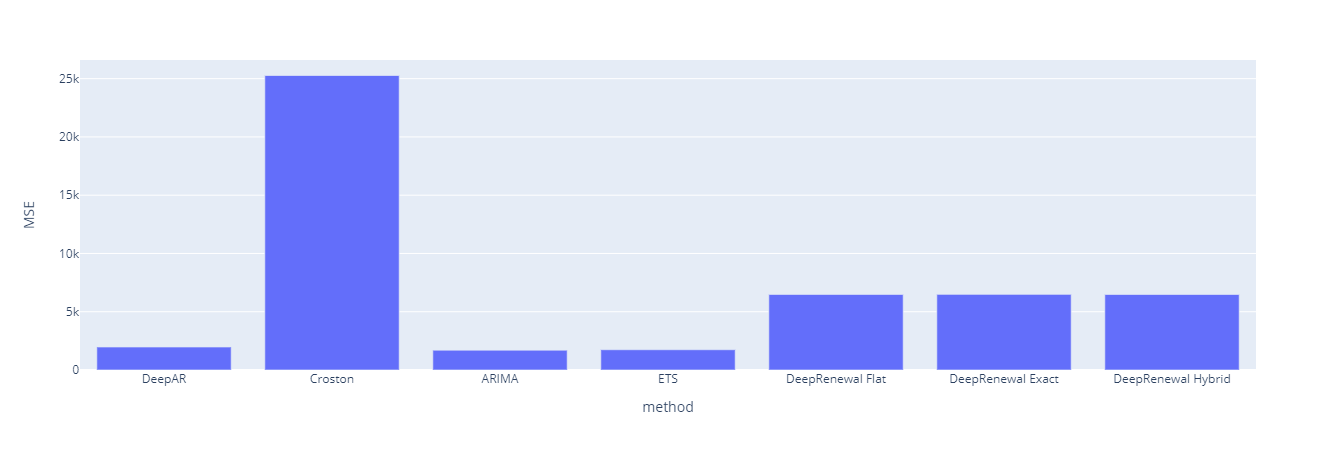

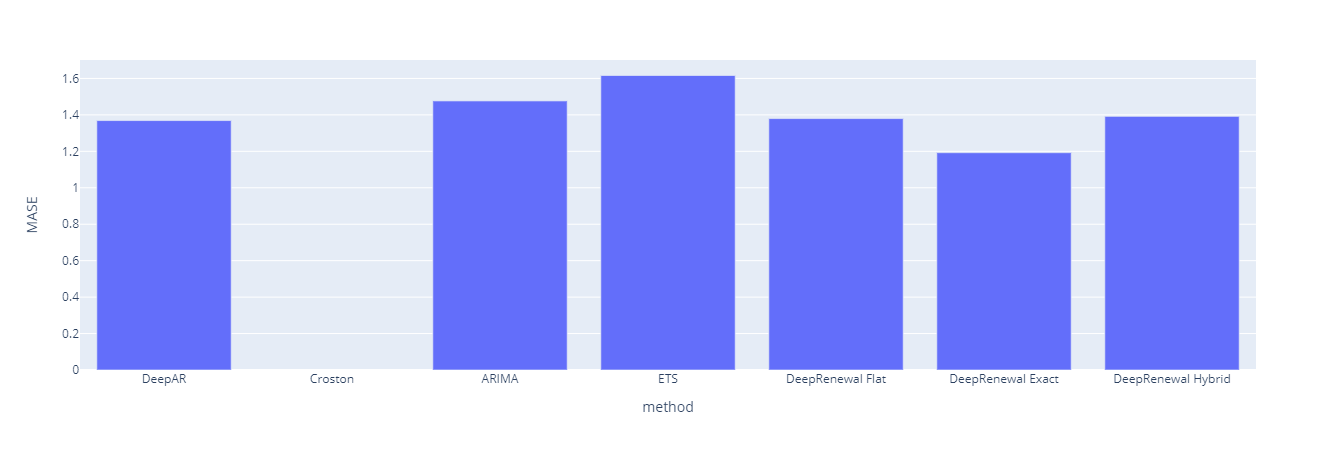

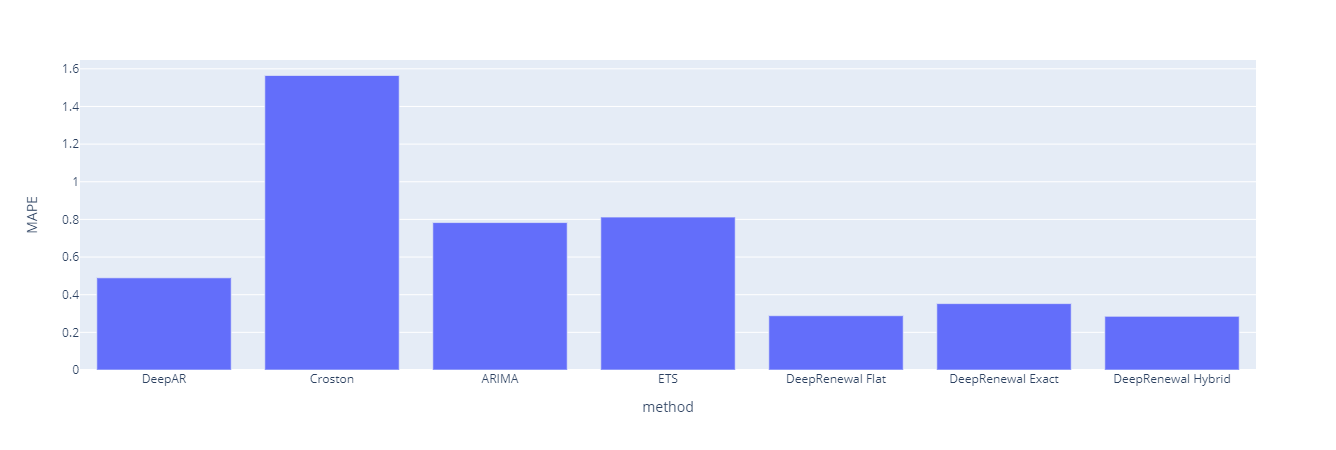

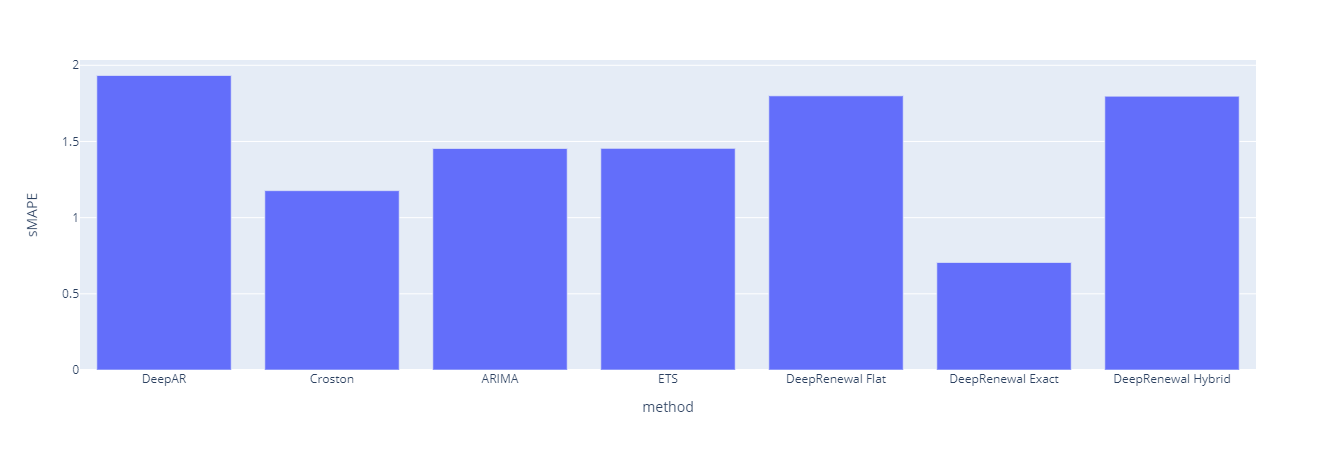

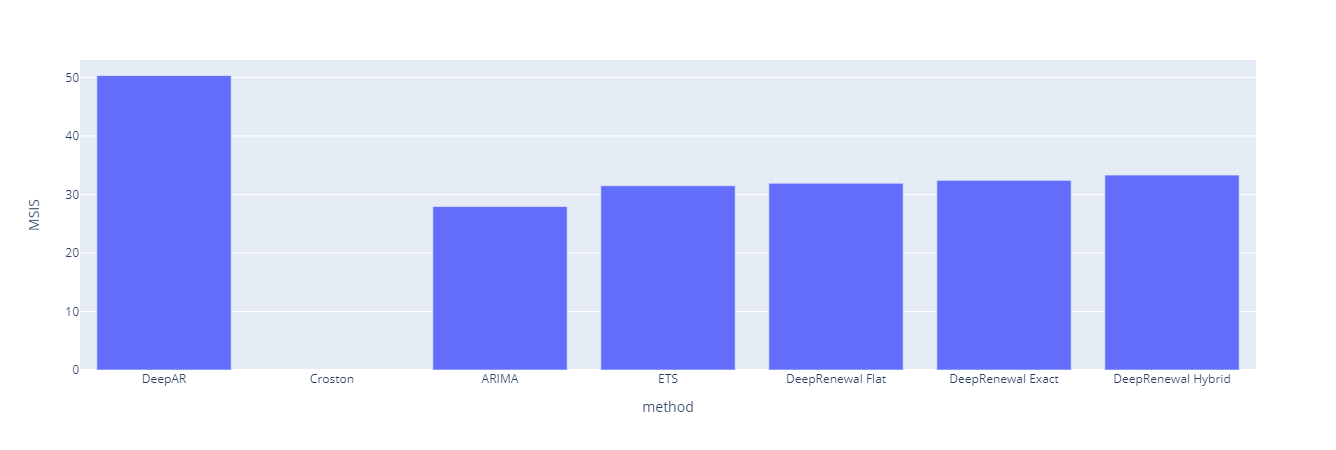

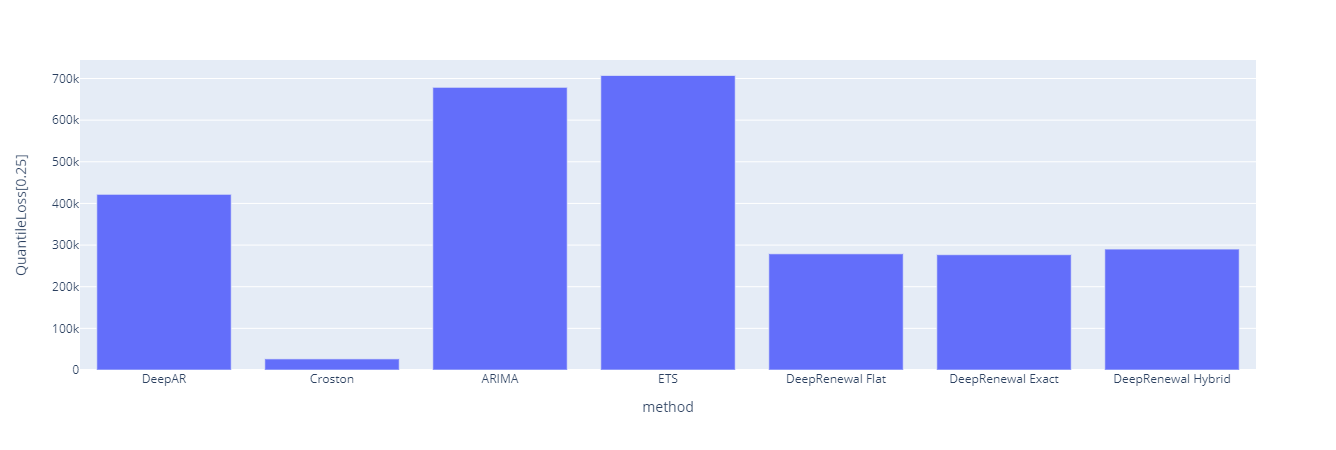

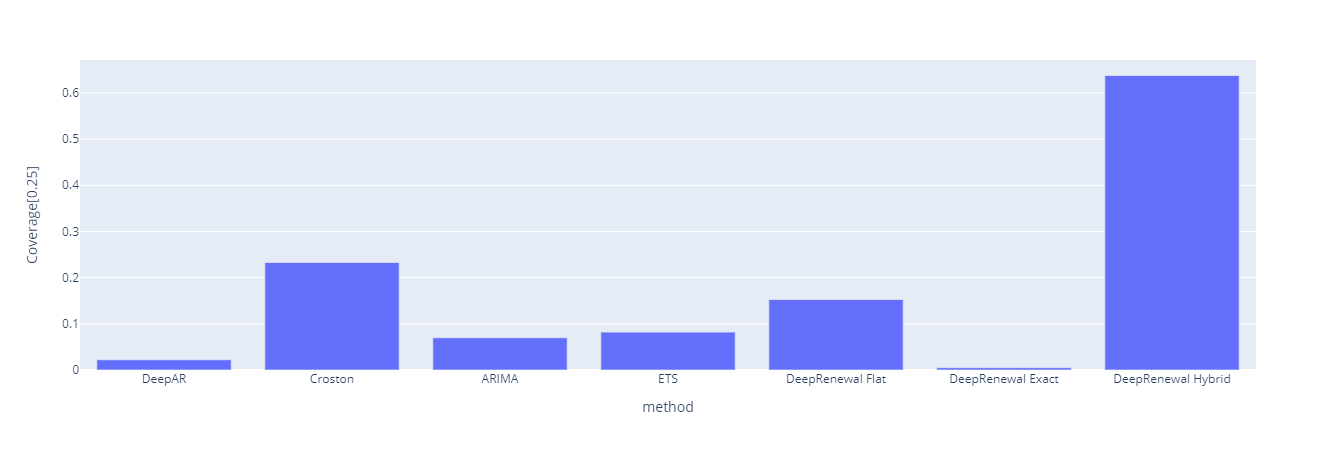

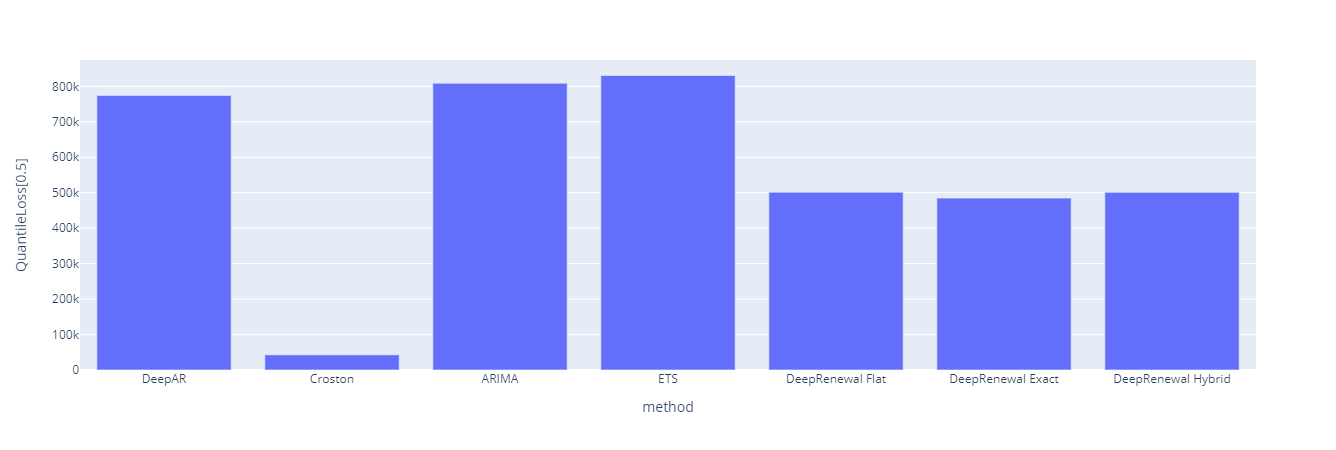

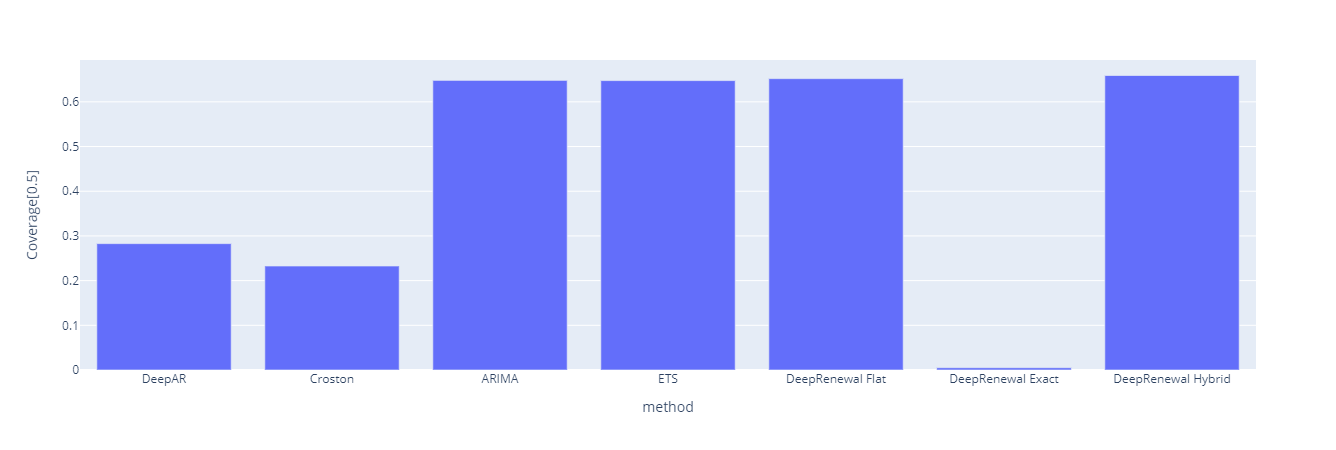

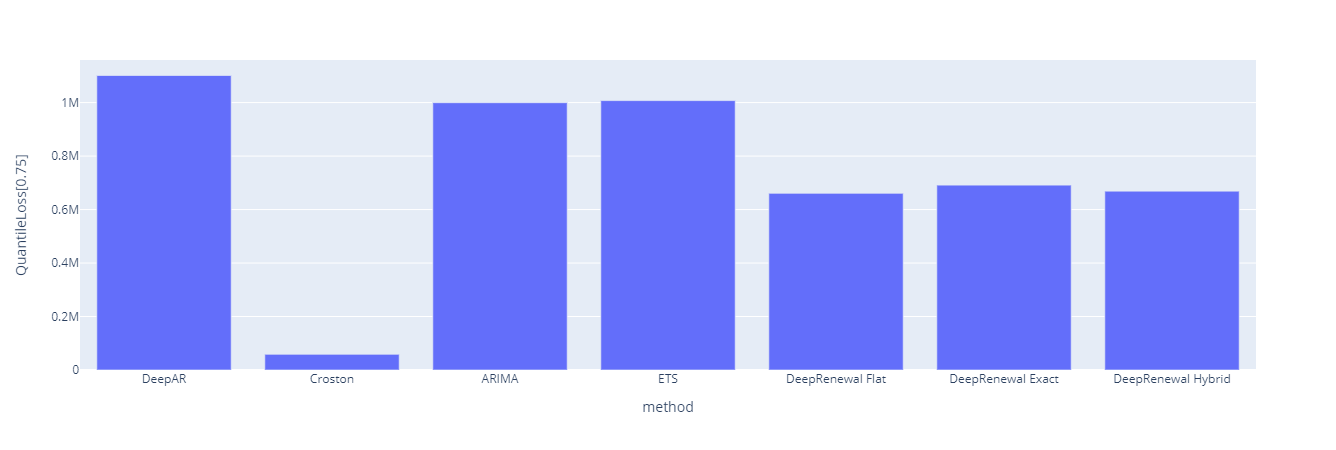

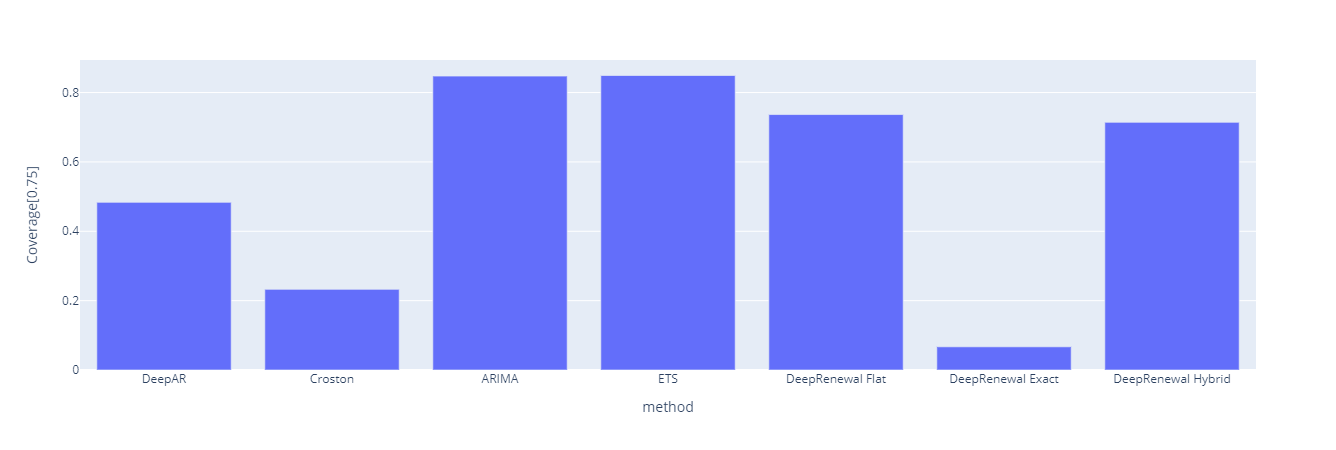

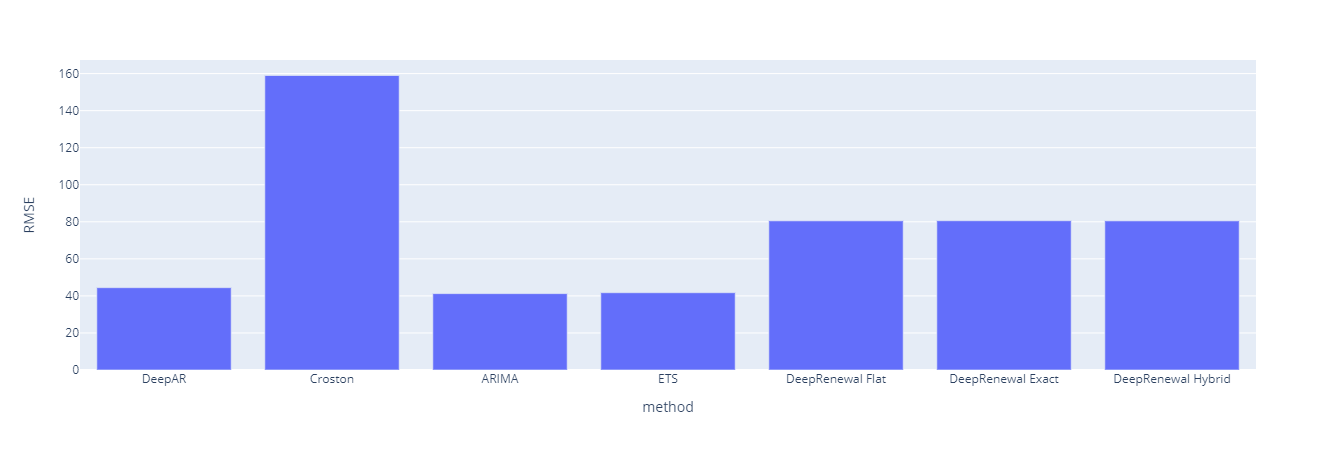

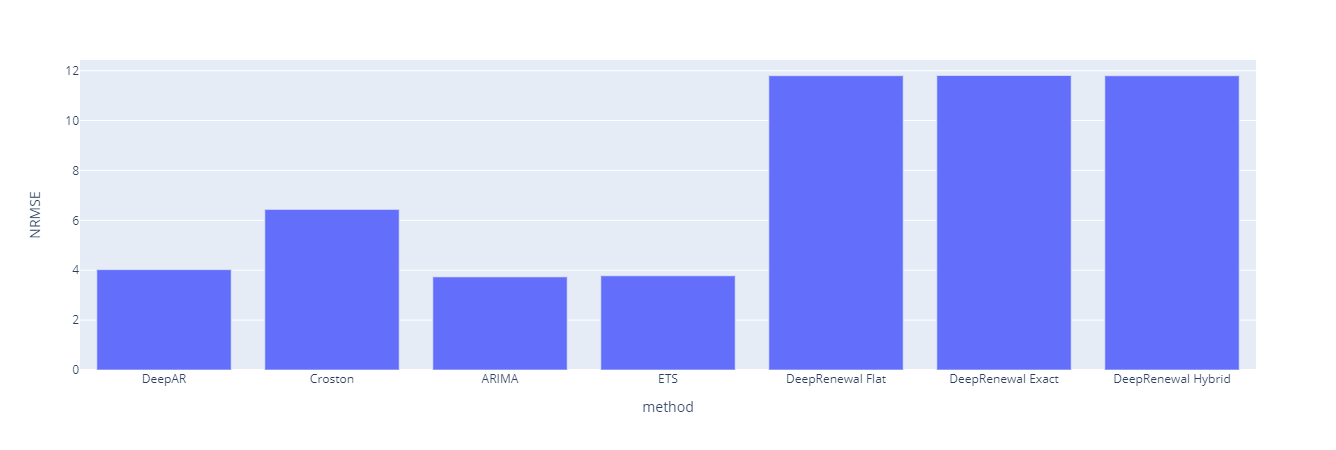

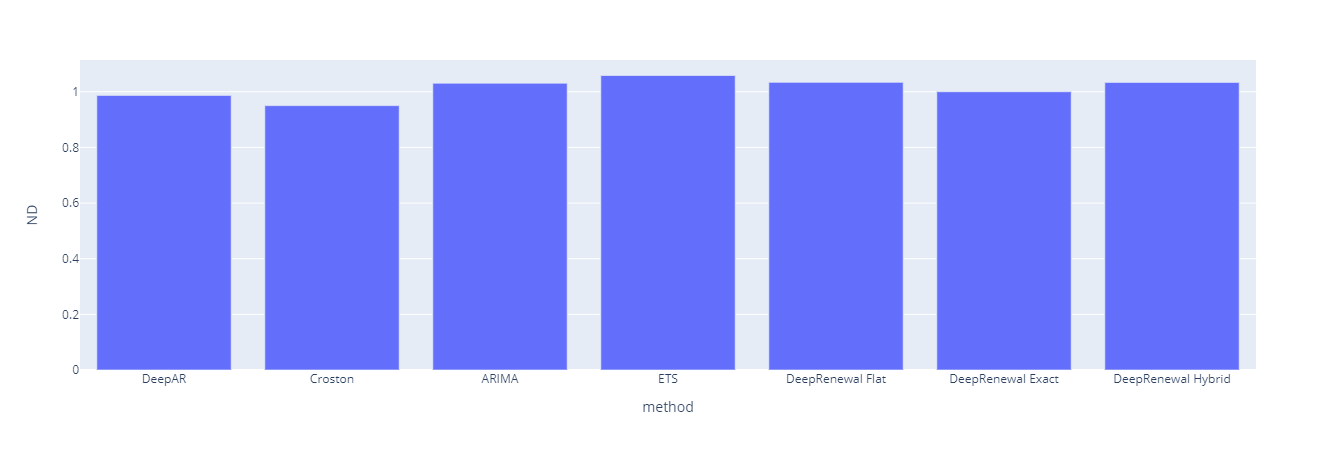

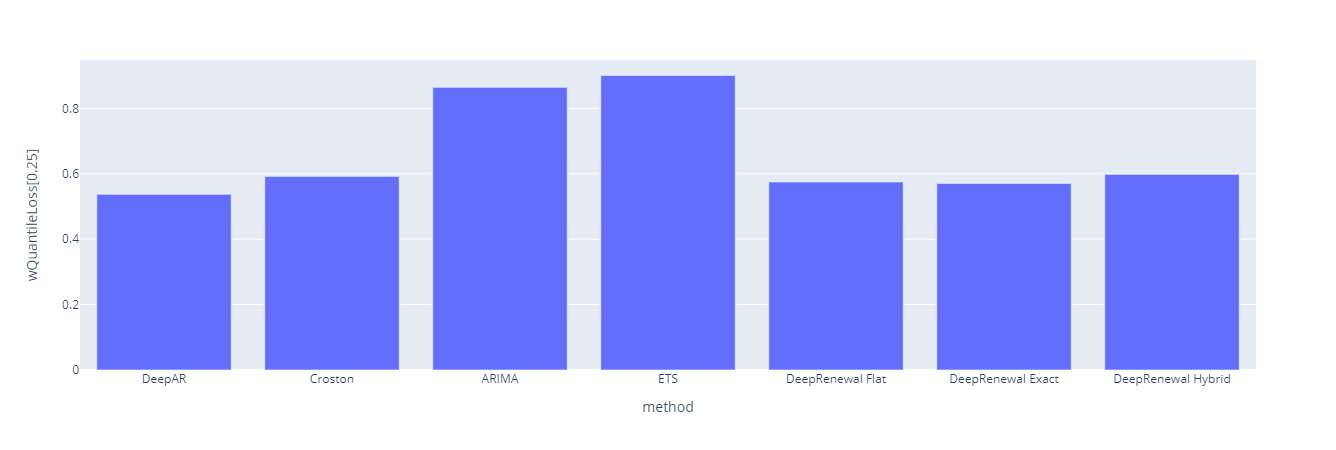

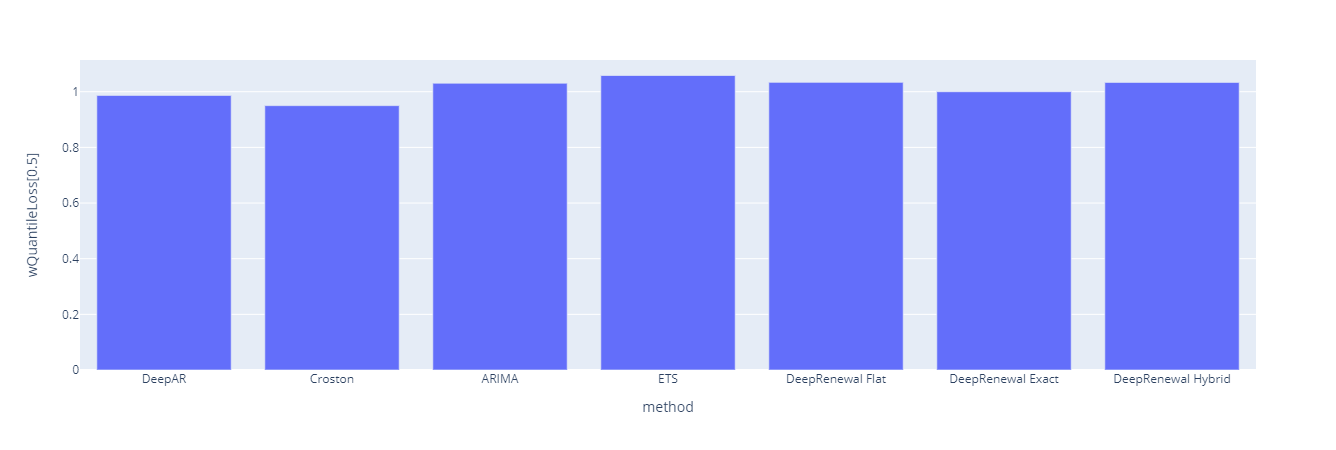

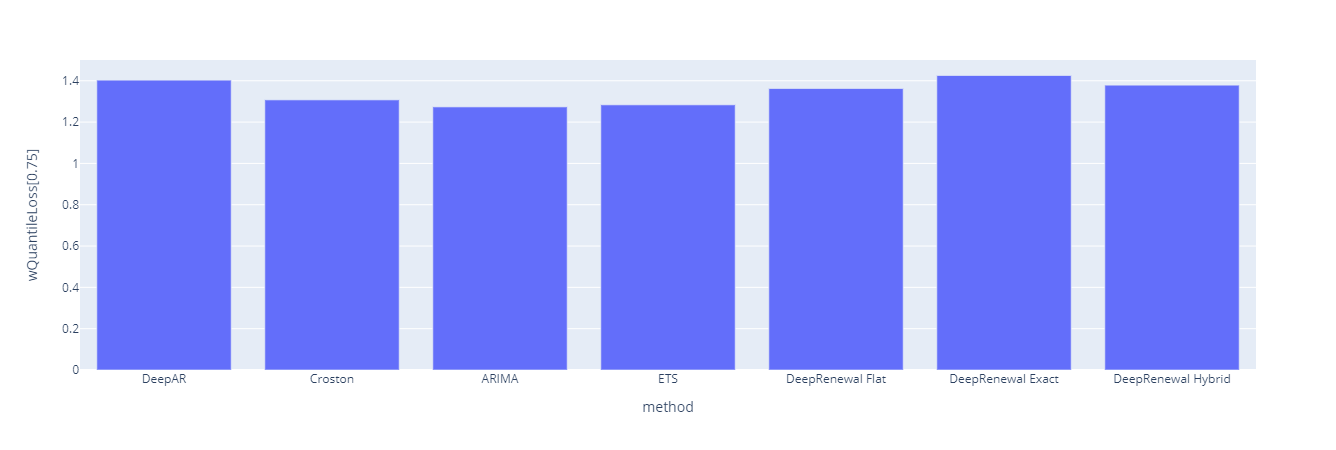

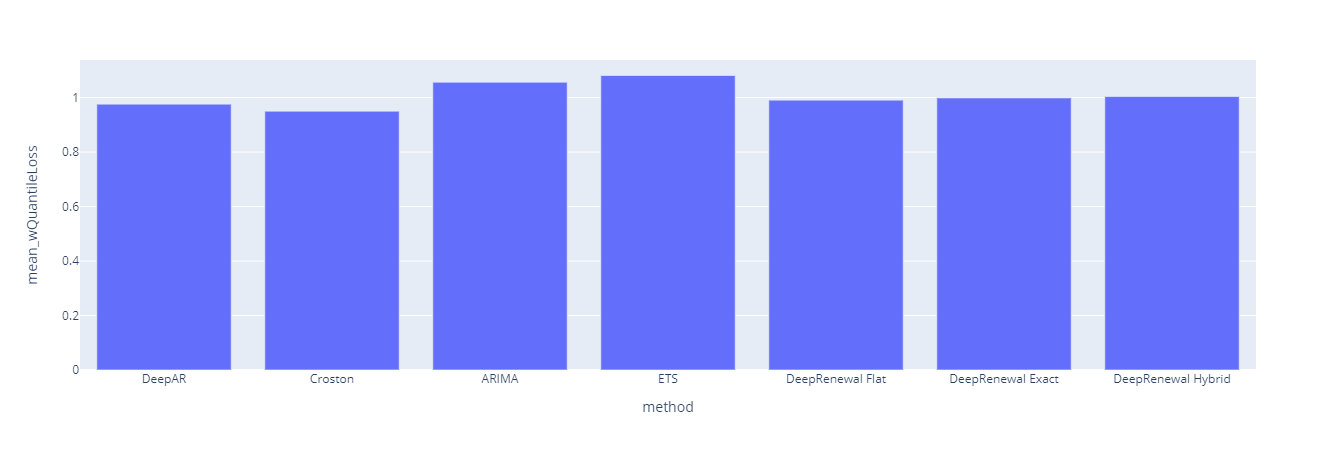

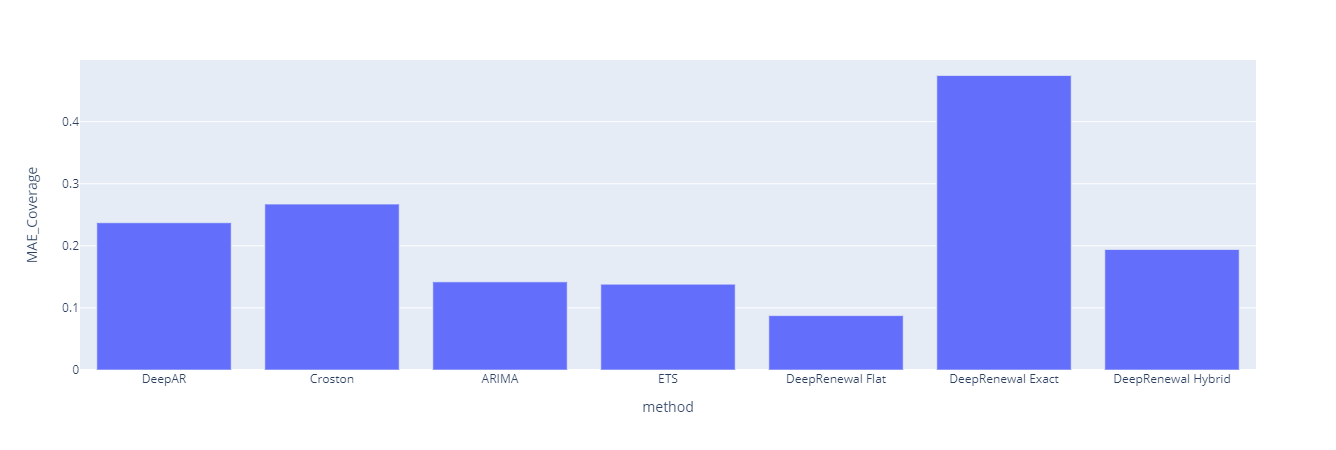

In [45]:
for metric in ['MSE', 'MASE', 'MAPE', 'sMAPE', 'MSIS',
       'QuantileLoss[0.25]', 'Coverage[0.25]', 'QuantileLoss[0.5]',
       'Coverage[0.5]', 'QuantileLoss[0.75]', 'Coverage[0.75]', 'RMSE',
       'NRMSE', 'ND', 'wQuantileLoss[0.25]', 'wQuantileLoss[0.5]',
       'wQuantileLoss[0.75]', 'mean_wQuantileLoss', 'MAE_Coverage']:
    fig = px.bar(result_df[['method',metric]], x="method", y=metric)
    fig.show()

In [31]:
# _max = result_df.max(axis=0)
# _result = result_df.copy()
# for col in result_df.columns:
#     if col != "method":
#         _result[col] = _result[col]/_max[col]
        

In [38]:
plot_df = pd.melt(result_df,id_vars = "method", var_name="Metric")
plot_df.head()

,method,Metric,value
0,DeepAR,MSE,1975.413661
1,Croston,MSE,25270.654456
2,ARIMA,MSE,1700.338294
3,ETS,MSE,1740.865039
4,DeepRenewal Flat,MSE,6483.959159


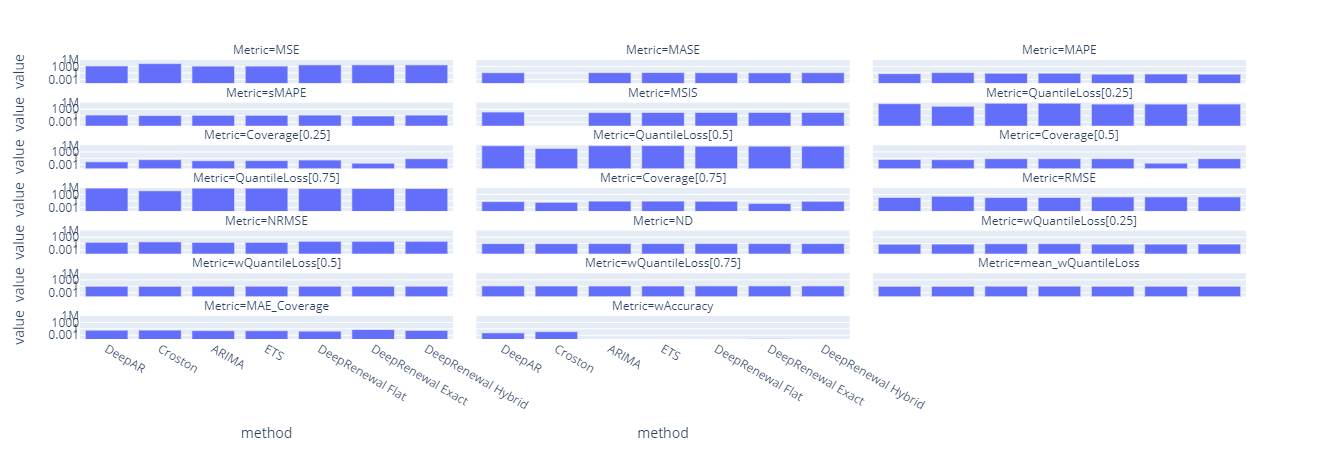

In [41]:
px.bar(plot_df, x="method", y="value", facet_col="Metric", facet_col_wrap=3, log_y=True)